# 目標
使用簡單的Keras模型來分類不同診斷結果的x-rays

## 引入套件 + 資料

In [0]:
import numpy as np
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

###################################################################################################
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
###################################################################################################

from itertools import chain

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
img001_xray = pd.read_csv('input/Data_Entry_2017_img001.csv')
img001_xray.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [0]:
# img001_xray['Finding Labels'] = img001_xray['Finding Labels'].loc[(img001_xray['Finding Labels'] != 'No Finding') & 
#                                                                   (img001_xray['Finding Labels'] != 'Infiltration') &
#                                                                   (img001_xray['Finding Labels'] != 'Atelectasis') &
#                                                                   (img001_xray['Finding Labels'] != 'Effusion') &
#                                                                   (img001_xray['Finding Labels'] != 'Nodule') &
#                                                                   (img001_xray['Finding Labels'] != 'Fibrosis') &
#                                                                   (img001_xray['Finding Labels'] != 'Pneumothorax') &
#                                                                   (img001_xray['Finding Labels'] != 'Cardiomegaly') &
#                                                                   (img001_xray['Finding Labels'] != 'Consolidation') &
#                                                                   (img001_xray['Finding Labels'] != 'Pleural_Thickening') &
#                                                                   (img001_xray['Finding Labels'] != 'Mass') &
#                                                                   (img001_xray['Finding Labels'] != 'Emphysema') &
#                                                                   (img001_xray['Finding Labels'] != 'Edema') &
#                                                                   (img001_xray['Finding Labels'] != 'Pneumonia') &
#                                                                   (img001_xray['Finding Labels'] != 'Hernia')
#                                                                  == 0]

In [0]:
# img001_xray

In [0]:
# img001_xray = img001_xray.drop(img001_xray.loc[img001_xray['Finding Labels'].isnull()].index)

In [0]:
# img001_xray.to_csv('train_one_label.csv', index=False)

## 建立Label圖檔連結欄位

In [0]:
img001_xray = pd.read_csv('input/Data_Entry_2017_img001.csv')
image001_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('input', 'images*', '*.png'))}
print('Scans found:', len(image001_paths), ', Total Headers', img001_xray.shape[0])
img001_xray['path'] = img001_xray['Image Index'].map(image001_paths.get)
# img001_xray['Patient Age'] = img001_xray['Patient Age'].map(lambda x: int(x[:-1]))
print(img001_xray.info())
img001_xray.head()

Scans found: 4999 , Total Headers 4999
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 12 columns):
Image Index                    4999 non-null object
Finding Labels                 4999 non-null object
Follow-up #                    4999 non-null int64
Patient ID                     4999 non-null int64
Patient Age                    4999 non-null int64
Patient Gender                 4999 non-null object
View Position                  4999 non-null object
OriginalImage[Width            4999 non-null int64
Height]                        4999 non-null int64
OriginalImagePixelSpacing[x    4999 non-null float64
y]                             4999 non-null float64
path                           4999 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 468.7+ KB
None


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,input\images_001\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,input\images_001\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,input\images_001\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,input\images_001\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,input\images_001\00000003_000.png


## Label前處理

No Finding                           2754
Infiltration                          417
Atelectasis                           192
Effusion                              156
Nodule                                106
Fibrosis                               94
Pneumothorax                           90
Cardiomegaly                           72
Consolidation                          64
Pleural_Thickening                     62
Atelectasis|Infiltration               62
Mass                                   60
Emphysema                              55
Effusion|Infiltration                  50
Atelectasis|Effusion                   33
Cardiomegaly|Effusion                  30
Consolidation|Infiltration             29
Infiltration|Nodule                    24
Atelectasis|Effusion|Infiltration      23
Atelectasis|Consolidation              19
Fibrosis|Infiltration                  19
Pneumonia                              18
Edema                                  18
Consolidation|Effusion            

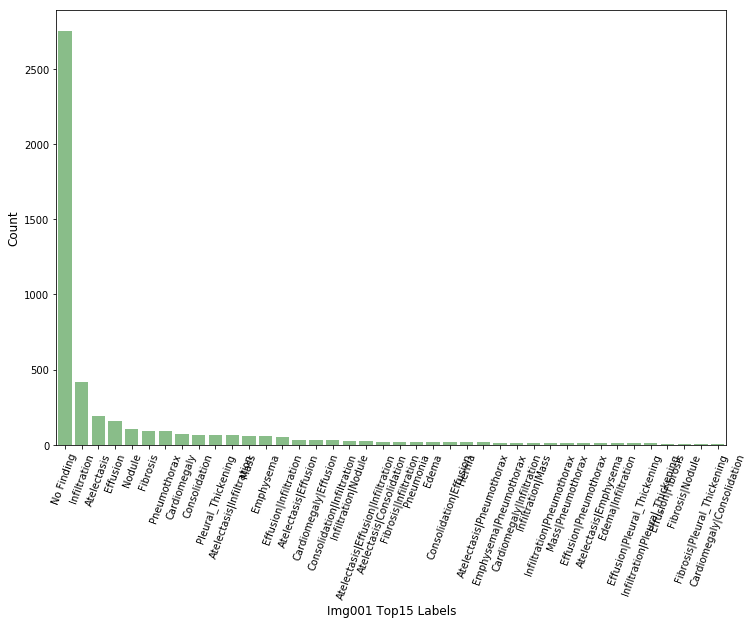

In [0]:
# 列出所有label 包含複數label的觀察值
# img001_lb_counts = img001_xray['Finding Labels'].value_counts()

# 列出前15多的label 包含複數label的觀察值
img001_lb_counts = img001_xray['Finding Labels'].value_counts()[:40]
print(img001_lb_counts)

plt.figure(figsize=(12,8))
sns.barplot(img001_lb_counts.index, img001_lb_counts.values, alpha=0.6, color=color[2]) 
plt.xlabel("Img001 Top15 Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=70)
plt.show()

單一label + "No Finding" = 4175 (83.5%)

複數label = 824 (16.5%)

In [0]:
# 將健康者(No Finding)的label轉為空值
img001_xray['Finding Labels'] = img001_xray['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

#將label欄位的所有值以|拆分 並取出不重複值
img001_all_labels = np.unique(list(chain(*img001_xray['Finding Labels'].map(lambda x: x.split('|')).tolist())))

#label 不含健康者 不重複 的數量
img001_labels_count = len(img001_all_labels)-1
print('Img001 Label Counts:' + str(img001_labels_count))
print(img001_all_labels[1:])

#將不為0(健康者)、不重複的label新增一個one-hot-encoder的欄位 
for c_label in img001_all_labels:
    if len(c_label)>1: # leave out empty labels
        img001_xray[c_label] = img001_xray['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
print(img001_xray.info())
img001_xray.head()

Img001 Label Counts:14
['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 26 columns):
Image Index                    4999 non-null object
Finding Labels                 4999 non-null object
Follow-up #                    4999 non-null int64
Patient ID                     4999 non-null int64
Patient Age                    4999 non-null int64
Patient Gender                 4999 non-null object
View Position                  4999 non-null object
OriginalImage[Width            4999 non-null int64
Height]                        4999 non-null int64
OriginalImagePixelSpacing[x    4999 non-null float64
y]                             4999 non-null float64
path                           4999 non-null object
Atelectasis                    4999 non-null float64
Cardiomegaly     

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 觀察14種診斷結果的數量

In [0]:
# print(img001_all_labels)
# print(img001_xray.columns[12:])
# print(img001_xray['Atelectasis'].loc[img001_xray['Atelectasis'] == 1 ].count())
#################################################################################
print('img001_all_labels: '+str(len(img001_xray.columns[12:]))) #remove "no finding" 
print('----------------------------------------------------------------------------')
print('Atelectasis count: '+str(img001_xray['Atelectasis'].sum()))
print('Cardiomegaly count: '+str(img001_xray['Cardiomegaly'].sum()))
print('Consolidation count: '+str(img001_xray['Consolidation'].sum()))
print('Edema count: '+str(img001_xray['Edema'].sum()))
print('Effusion count: '+str(img001_xray['Effusion'].sum()))

print('Emphysema count: '+str(img001_xray['Emphysema'].sum()))
print('Fibrosis count: '+str(img001_xray['Fibrosis'].sum()))
print('Hernia count: '+str(img001_xray['Hernia'].sum()))
print('Infiltration count: '+str(img001_xray['Infiltration'].sum()))
print('Mass count: '+str(img001_xray['Mass'].sum()))

print('Nodule count: '+str(img001_xray['Nodule'].sum()))
print('Pleural_Thickening count: '+str(img001_xray['Pleural_Thickening'].sum()))
print('Pneumonia count: '+str(img001_xray['Pneumonia'].sum()))
print('Pneumothorax count: '+str(img001_xray['Pneumothorax'].sum()))
print('----------------------------------------------------------------------------')
index = [0]
img001_all_labels = np.delete(img001_all_labels, index)
print("after img001_all_labels: "+str(len(img001_all_labels)))
print(img001_all_labels)


# print('----------------------------------------------------------------------------')
# # keep at least 50 cases
# print("before img001_all_labels: "+str(len(img001_all_labels)))
# print(img001_all_labels)
#print('----------------------------------------------------------------------------')
# index = [0,8]
# img001_all_labels = np.delete(img001_all_labels, index)
# print("after img001_all_labels: "+str(len(img001_all_labels)))
# print(img001_all_labels)

img001_all_labels: 14
----------------------------------------------------------------------------
Atelectasis count: 460.0
Cardiomegaly count: 196.0
Consolidation count: 205.0
Edema count: 90.0
Effusion count: 487.0
Emphysema count: 125.0
Fibrosis count: 172.0
Hernia count: 27.0
Infiltration count: 830.0
Mass count: 161.0
Nodule count: 214.0
Pleural_Thickening count: 165.0
Pneumonia count: 65.0
Pneumothorax count: 199.0
----------------------------------------------------------------------------
after img001_all_labels: 14
['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [0]:
# teat_Hernia = img001_xray.loc[img001_xray['Hernia'] == 1.0]
# teat_Hernia.to_csv('teat_Hernia.csv', index=False)

In [0]:
print(img001_xray.shape)
img001_xray.head(3)

(4999, 26)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
img001_xray.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

>??將數據量較少的疾病 'Hernia' 剔除

>??由於數據集非常公正，我們可以將其重新採樣為更合理的集合、weight = 0.1 + findings

>??計算2000筆、前15名label的數量及比例

In [0]:
# sample_weights = img001_xray['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
# sample_weights /= sample_weights.sum()
# img001_xray = img001_xray.sample(2000, weights=sample_weights)
# # img001_xray

# label_counts = img001_xray['Finding Labels'].value_counts()[:15]
# print(type(label_counts))
# label_counts

# plt.figure(figsize=(12,8))
# sns.barplot(label_counts.index, label_counts.values, alpha=0.6, color=color[3]) 
# plt.xlabel("Img001 Top15 Labels chweit", fontsize=12)
# plt.ylabel("Count", fontsize=12)
# plt.xticks(rotation=70)
# plt.show()

# plt.figure(figsize=(12,8))
# sns.barplot(label_counts.index, label_counts.values/2000*100, alpha=0.6, color=color[3]) 
# plt.xlabel("Img001 Top15 Labels chweit", fontsize=12)
# plt.ylabel("Percent(%)", fontsize=12)
# plt.xticks(rotation=70)
# plt.show()

## 準備培訓數據
將數據分成train和validation，建立disease_vec欄位(疾病狀態的one-hot-encoder list)

In [0]:
# 將img001中所有disease做成one-hot-encoder list
img001_xray['disease_vec'] = img001_xray.apply(lambda x: [x[img001_all_labels].values], 1).map(lambda x: x[0])
# img001_xray[['disease_vec']].tail(20).values

In [0]:
img001_xray.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [0]:
# 將與原欄位進行驗證
# img001_xray[['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
#  'Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule',
#  'Pleural_Thickening','Pneumonia','Pneumothorax']].tail(20)

In [0]:
#分測試及驗證資料
train_df, valid_df = train_test_split(img001_xray, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = img001_xray['Finding Labels'].map(lambda x: x[:4]))
print(train_df.shape, valid_df.shape)
print('train count:', train_df.shape[0], 'validation count:', valid_df.shape[0])

(3749, 27) (1250, 27)
train count: 3749 validation count: 1250


In [0]:
# valid_df.loc[40]

## 建立數據生成器
製作數據生成器，用於載入和隨機轉換圖像

In [0]:
# 設定圖形大小
IMG_SIZE = (128, 128)
# 圖形預處理(https://zhuanlan.zhihu.com/p/30197320)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [0]:
# 數據生成 function
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [0]:
train_gen = flow_from_dataframe(core_idg,  #圖形預處理
                                train_df,  #處理train_df的圖
                                path_col = 'path',  #圖片路徑
                                y_col = 'disease_vec',  #label
                                target_size = IMG_SIZE,  #圖形大小
                                color_mode = 'grayscale',  #圖形型態
                                batch_size = 32)  #每次訓練的大小

valid_gen = flow_from_dataframe(core_idg, 
                                valid_df, 
                                path_col = 'path',
                                y_col = 'disease_vec', 
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale',
                                batch_size = 256)  #每次驗證的樣大小

#用固定的資料來評估演算法(將valid_df拆成text_X、text_Y)
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'disease_vec', 
                                          target_size = IMG_SIZE,
                                          color_mode = 'grayscale',
                                          batch_size = 1024))  #每次評估的大小

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3749 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1250 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1250 images


In [0]:
img001_xray_gen = flow_from_dataframe(core_idg, 
                                    img001_xray, 
                                    path_col = 'path',
                                    y_col = 'disease_vec', 
                                    target_size = IMG_SIZE,
                                    color_mode = 'grayscale',
                                    batch_size = 256)  #每次驗證的樣大小

#用固定的資料來評估演算法(將valid_df拆成text_X、text_Y)
test_X2, test_Y2 = next(flow_from_dataframe(core_idg, 
                                            img001_xray,
                                            path_col = 'path',
                                            y_col = 'disease_vec', 
                                            target_size = IMG_SIZE,
                                            color_mode = 'grayscale',
                                            batch_size = 4999))  #每次評估的大小

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4999 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4999 images


In [0]:
test_X2.shape

(4999, 128, 128, 1)

In [0]:
test_Y2.shape

(4999, 14)

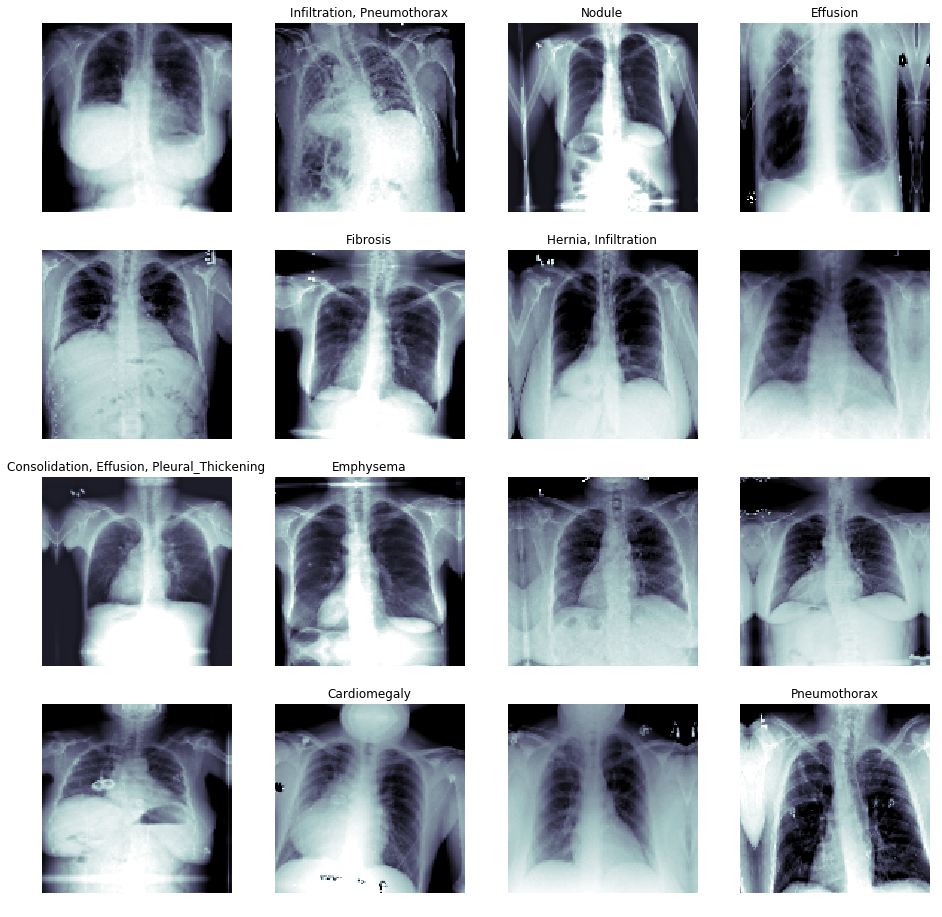

In [0]:
# 4x4亂數x-ray呈現
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(img001_all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# t_x
# t_x
# print(t_x.shape)
# print(t_y.shape)

In [0]:
t_x.shape

(32, 128, 128, 1)

In [0]:
t_y.shape

(32, 14)

## 建立一個簡單的模型
使用MobileNet作為基礎，添加GAP層（也可以添加Flatten）製作一個簡單的模型來訓練，而dropout和完全連接層用來計算特定功能

In [0]:
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(img001_all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1024)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 14)                7182      
Total params: 3,760,270
Trainable params: 3,738,382
Non-trainable params: 21,888
_____________________________________________________________

In [0]:
weight_path="{}_weights.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

## 首次訓練
希望能取得一些初步結果

In [0]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 2053s 21s/step - loss: 0.2697 - binary_accuracy: 0.9411 - mean_absolute_error: 0.0938 - val_loss: 0.6243 - val_binary_accuracy: 0.9507 - val_mean_absolute_error: 0.0535

Epoch 00001: val_loss improved from inf to 0.62431, saving model to xray_class_weights.best.hdf5


## 儲存模型

In [0]:
# 將模型儲存至 HDF5 檔案中
multi_disease_model.save('Xray_model_1.hdf5')  

## 檢查輸出

In [0]:
for c_label, s_count in zip(img001_all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.38%
Cardiomegaly: 3.91%
Consolidation: 4.49%
Edema: 1.66%
Effusion: 10.25%
Emphysema: 2.34%
Fibrosis: 3.52%
Hernia: 0.49%
Infiltration: 17.68%
Mass: 2.83%
Nodule: 4.39%
Pleural_Thickening: 3.12%
Pneumonia: 0.98%
Pneumothorax: 4.00%


In [0]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y

1024/1024 [==============================] - 135s 132ms/step


array([[2.3021564e-24, 4.8576121e-12, 1.0681890e-28, ..., 8.1405145e-26,
        1.2046116e-15, 2.5212595e-12],
       [4.4049339e-05, 5.9238514e-03, 1.1586102e-06, ..., 1.0105695e-05,
        4.1997863e-04, 1.9683694e-03],
       [8.7821104e-25, 3.6238404e-12, 3.3580277e-29, ..., 2.7650046e-26,
        6.3324024e-16, 1.0121193e-12],
       ...,
       [7.4252648e-19, 9.4768042e-09, 4.6305913e-22, ..., 9.7137810e-20,
        6.5759221e-12, 2.0865321e-09],
       [4.2285331e-10, 4.1450898e-05, 2.3504443e-12, ..., 3.4128665e-11,
        2.5715738e-07, 2.6625763e-05],
       [2.0215512e-07, 7.7357364e-04, 2.3926179e-09, ..., 2.5378956e-08,
        1.7525892e-05, 1.7410285e-04]], dtype=float32)

In [0]:
prediction = multi_disease_model.predict_classes(test_X, batch_size = 32, verbose = True)
prediction

1024/1024 [==============================] - 224s 219ms/step


array([8, 8, 8, ..., 8, 5, 8], dtype=int64)

In [0]:
prediction[11]

5

## ROC曲線
顯示每個疾病的ROC曲線

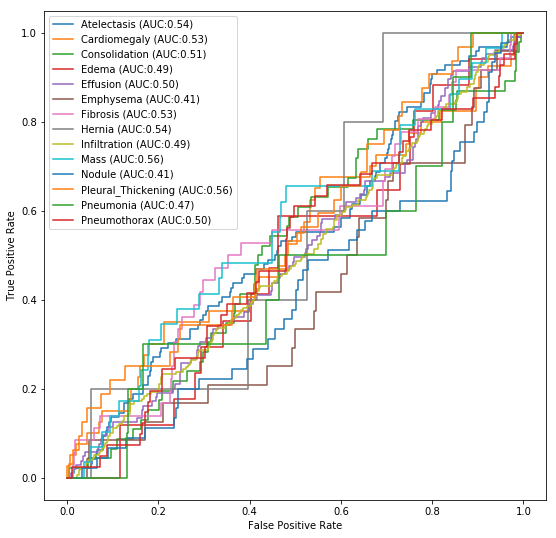

In [0]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(img001_all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [0]:
print(test_Y[:,idx].shape)
test_Y[:,idx].astype(int)

(1024,)


array([0, 0, 0, ..., 0, 0, 0])

In [0]:
print(pred_Y[:,idx].shape)
pred_Y[:,idx]

(1024,)


array([2.5212595e-12, 1.9683694e-03, 1.0121193e-12, ..., 2.0865321e-09,
       2.6625763e-05, 1.7410285e-04], dtype=float32)

## 進階訓練

In [0]:
# multi_disease_model.fit_generator(train_gen, 
#                                   steps_per_epoch = 100,
#                                   validation_data =  (test_X, test_Y), 
#                                   epochs = 5, 
#                                   callbacks = callbacks_list)

In [0]:
# 載入最佳權重
# multi_disease_model.load_weights(weight_path)

In [0]:
# pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [0]:
# 看看演算法預測某些診斷結果的頻率
# for c_label, p_count, t_count in zip(img001_all_labels, 
#                                      100*np.mean(pred_Y,0), 
#                                      100*np.mean(test_Y,0)):
#     print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [0]:
# fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
# for (idx, c_label) in enumerate(img001_all_labels):
#     fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
#     c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# fig.savefig('trained_net.png')

## 顯示部分圖像和相關的預測

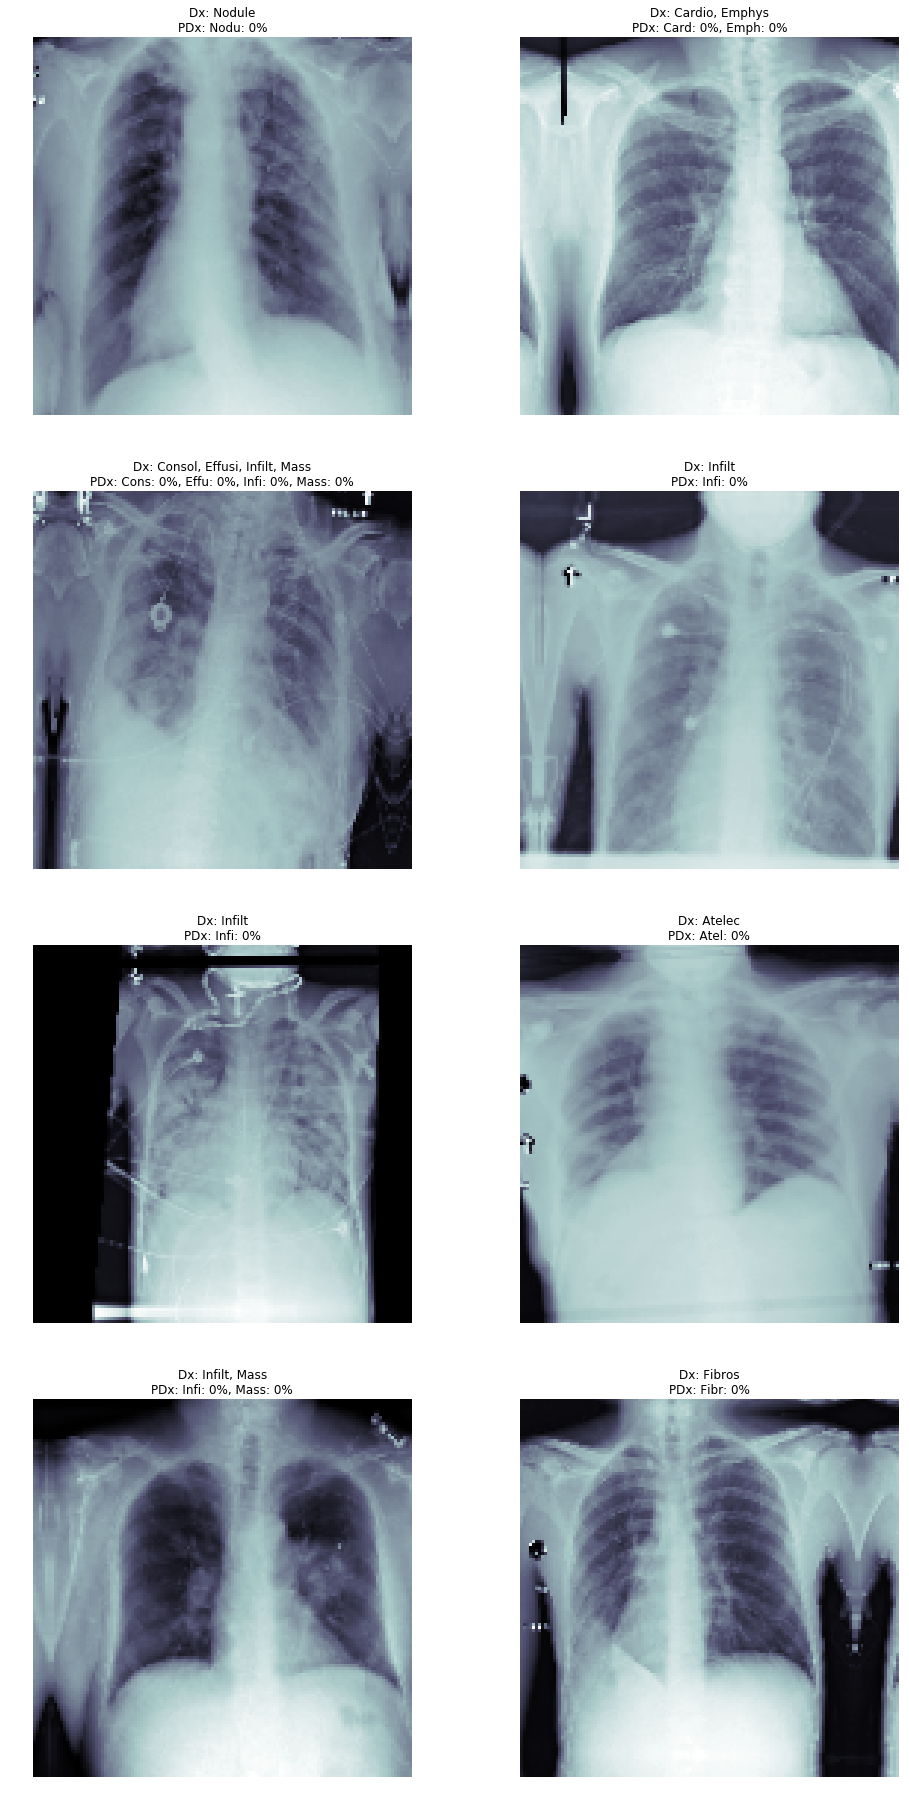

In [0]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(img001_all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(img001_all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')